# Generation of access requests with different probability dsitribution

In [1]:
### Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon

In [2]:
### User and resource attributes for each dataset

DS_ID = "IoT" # Availables => user_attributes.keys()
# OUT_FILE = open(DS_ID+".output", "w") # File to save the outputs

USER_ATTRS = {"IoT": ["role", "age", "health", "uname"],
              "AMZ": ["MGR_ID","ROLE_ROLLUP_1","ROLE_ROLLUP_2","ROLE_DEPTNAME","ROLE_TITLE","ROLE_FAMILY_DESC","ROLE_FAMILY","ROLE_CODE"],
              "HC": ["position", "uward", "specialties", "teams", "agentfor", "uname"],
              "UN": ["position","departmentu","crsTaken","crsTaught","isChair", "uname"],
              "PM": ["adminroles","projects","departmentu","projectsled","expertiseu","isemployee","task","uname"]}

RES_ATTRS = {"IoT": ["area", "mode", "temperature", "lockstatus", "rname"],
             "AMZ":["RID"],
             "HC": ["type", "author", "patient", "topics", "tratingTeam", "rward", "rname"],
             "UN": ["type","student","departmentr","csr", "rname"],
             "PM": ["type","project","department","expertise","proprietary", "rname"]}

EDG_ATTRS = {"IoT": ["uname", "rname", "location", "timeday", "op", "ACTION"],
             "AMZ": ["uname", "rname"],
             "HC": ["uname", "rname"],
             "UN":["uname", "rname"],
             "PM":["uname", "rname"]}

def get_probability_distribution(n, sample_size, probability_parameters, type="normal",):
    """ Get the probability distribution for n elementsin sample size."""
    distri = None

    if type==None:
        return None

    if type=="normal":
        distri = np.random.normal(probability_parameters["mu"], 
                                  probability_parameters["sigma"], 
                                  size=sample_size)        

    if type=="pareto":        
        distri = (np.random.pareto(probability_parameters["alpha"], sample_size) + 1) * probability_parameters["mu"]        

    if type=="poisson":
        distri = np.random.poisson(probability_parameters["lam"],
                                   size=sample_size)        

    if type=="exponential":
        new_scale = 1 / probability_parameters["lam"]
        # Generate values for the x-axis
        x = np.linspace(0, n, sample_size)
        # Calculate the PDF with the new scale parameter
        distri = expon.pdf(x, scale=new_scale)

    if type=="uniform":
        distri = np.random.uniform(probability_parameters["low"],
                                   probability_parameters["high"],
                                   size=sample_size)

    count, _, _ = plt.hist(distri, n)  
    return count/sample_size

def add_unique_identifier(df, subset_columns):
    # Obtener registros únicos
    unique_records = df.drop_duplicates(subset=subset_columns).copy()

    # Agregar un identificador único
    unique_records['uname'] = range(1, len(unique_records) + 1)

    # Fusionar los registros únicos con el dataframe original
    result_df = pd.merge(df, unique_records, on=subset_columns, how='left')

    return result_df

def resize_distribution(prob_distribution, new_size):
    """
    Resize the probability distribution to a new size using linear interpolation.

    Parameters:
    - prob_distribution (list): The original probability distribution.
    - new_size (int): The desired size of the new probability distribution.

    Returns:
    - list: The resized probability distribution.
    """
    old_size = len(prob_distribution)

    # Create indices for the old and new arrays
    old_indices = np.linspace(0, old_size - 1, old_size)
    new_indices = np.linspace(0, old_size - 1, new_size)

    # Use linear interpolation to resize the distribution
    resized_distribution = np.interp(new_indices, old_indices, prob_distribution)

    # Normalize the distribution to ensure it sums to 1
    resized_distribution /= sum(resized_distribution)

    return resized_distribution

def get_sample_by_distribution(access_log, sample_size, prob_distri, class_name):
    """ Sampling a dataframe based on a given distribution. """
    new_sample = pd.DataFrame() # Store all access requests
    for i in prob_distri.iloc:    
        temp = access_log[access_log[class_name]==i[0]]
        n_samples = int(i[1]*sample_size) 
        if n_samples>0 and not temp.empty:            
            temp = temp.sample(n=n_samples, replace=True)
            new_sample = pd.concat([new_sample, temp])

    return new_sample

In [24]:
str_dataset = "UN"
#filename = "../data/"+str_dataset+"/0-"+str_dataset+"-universal-op.csv"
filename = "../data/"+str_dataset+"/"+str_dataset+"-universal-op.csv"

acc_log = pd.read_csv(filename)

# Remove first column (is the old index)
if not str_dataset in ["ML"]:
    acc_log = acc_log[acc_log.columns[1:]]

# Change the uname string values to int values
if not str_dataset in ["AMZ","ML"]:
    acc_log = acc_log.replace(acc_log.uname.unique(), range(len(acc_log.uname.unique())))

# Change the resource id
if not str_dataset in ["UN", "PM", "AMZ", "ML"]:
    acc_log["rname"] = acc_log["rname"] + max(acc_log.uname.unique()) + 1

print("Done!")
print(acc_log.head(5)) # Show the first five rows
print("|L| = ", len(acc_log))
# Delete some variables
del filename

Done!
   uname   position departmentu crsTaken crsTaught  isChair  \
0      0  applicant        none     none      none        0   
1      1    student          cs    cs101      none        0   
2      1    student          cs    cs101      none        0   
3      1    student          cs    cs101      none        0   
4      1    student          cs    cs101      none        0   

               rname         type student rDepartment    csr            op  \
0       application1  application       0        none   none   checkStatus   
1     cs101gradebook    gradebook    none          cs  cs101  readMyScores   
2     cs101gradebook    gradebook    none          ee  cs101  readMyScores   
3  csStu1application  application       1        none   none   checkStatus   
4        csStu1trans   transcript       1          cs   none          read   

   ACTION  
0       1  
1       1  
2       1  
3       1  
4       1  
|L| =  251793


In [25]:
### Properties

users = acc_log.uname.unique()
print("# users:", len(users), "\t Head ->", users[:5], "\t tail -> ", users[-5:])
rscs = acc_log.rname.unique()
print("# resources:", len(rscs), "\t Head ->", rscs[:5], "\t tail -> ", rscs[-5:])
print("Size of AL: \t", len(acc_log))
print("Size of +AL: \t",len(acc_log[acc_log.ACTION==1]), (len(acc_log[acc_log.ACTION==1])/len(acc_log))*100)
print("Size of -AL: \t",len(acc_log[acc_log.ACTION==0]), (len(acc_log[acc_log.ACTION==0])/len(acc_log))*100)

# users: 101 	 Head -> [0 1 2 3 4] 	 tail ->  [ 96  97  98  99 100]
# resources: 24 	 Head -> ['application1' 'cs101gradebook' 'csStu1application' 'csStu1trans'
 'cs601gradebook'] 	 tail ->  ['cs601roster' 'cs602roster' 'ee101roster' 'ee601roster' 'ee602roster']
Size of AL: 	 251793
Size of +AL: 	 1359 0.5397290631590235
Size of -AL: 	 250434 99.46027093684097


## AMZ Distribution

In [5]:
# Load ddata
amz_al = pd.read_csv("../data/AMZ/0-AMZ-universal.csv")

print("Done!")
print(amz_al.head(5)) # Show the first five rows

Done!
   Unnamed: 0  ACTION  rname  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  \
0           0       1  39353   85475         117961         118300   
1           1       1  17183    1540         117961         118343   
2           2       1  36724   14457         118219         118220   
3           3       1  36135    5396         117961         118343   
4           4       1  42680    5905         117929         117930   

   ROLE_DEPTNAME  ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  uname  
0         123472      117905            117906       290919     117908      1  
1         123125      118536            118536       308574     118539      2  
2         117884      117879            267952        19721     117880      3  
3         119993      118321            240983       290919     118322      4  
4         119569      119323            123932        19793     119325      5  


### Mapping Distribution

In [26]:
distribution_name = "Rw"

### USERS DISTRIBUTION
n_bins = len(users) # number of Users to map
to_plot = amz_al[USER_ATTRS["AMZ"]].value_counts(normalize=True, ascending=True)
test = list(to_plot.values)
resized_distribution = resize_distribution(test, n_bins)
print("USERS")
print("Original Distribution:", len(test))
print("Resized Distribution:", len(resized_distribution))
user_prob_distri = pd.DataFrame({"UID": users, "prob": resized_distribution})
print(user_prob_distri.info())

### RESOURCES DISTRIBUTION
n_bins = len(rscs) # Number of resources
to_plot = amz_al["rname"].value_counts(normalize=True, ascending=True)
test = list(to_plot.values)
resized_distribution = resize_distribution(test, n_bins)
print("\nRESOURCES")
print("Original Distribution:", len(test))
print("Resized Distribution:", len(resized_distribution))
res_prob_distri = pd.DataFrame({"RID": rscs, "prob": resized_distribution})
print(res_prob_distri.info())

USERS
Original Distribution: 9561
Resized Distribution: 101
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UID     101 non-null    int64  
 1   prob    101 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 1.7 KB
None

RESOURCES
Original Distribution: 7518
Resized Distribution: 24
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RID     24 non-null     object 
 1   prob    24 non-null     float64
dtypes: float64(1), object(1)
memory usage: 512.0+ bytes
None


## Others Distributions

### Normal

Users Done!


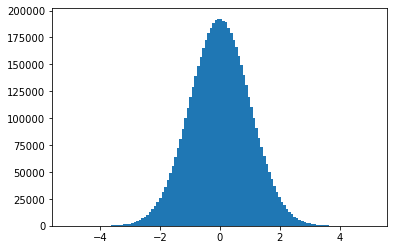

In [92]:
distribution_name = "Nr"

proba_param = {"mu": 0, "sigma": 1}
prob = get_probability_distribution(len(users), len(acc_log), proba_param, "normal")
user_prob_distri = pd.DataFrame({"UID": users, "prob": prob})
print("Users Done!")

Resouces Done!


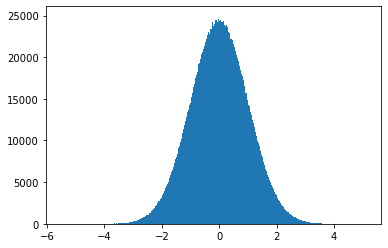

In [93]:
proba_param = {"mu": 0, "sigma": 1}
prob = get_probability_distribution(len(rscs), len(acc_log), proba_param, "normal")
res_prob_distri = pd.DataFrame({"UID": rscs, "prob": prob})
print("Resouces Done!")

### Poisson

Resources Done!


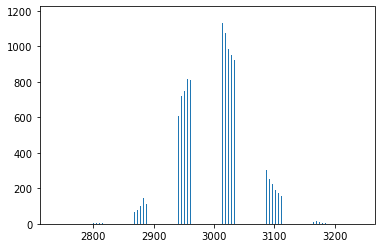

In [17]:
distribution_name = "Ps"

proba_param = {"lam": 3000}
prob = get_probability_distribution(len(rscs), len(acc_log), proba_param, "poisson")
res_prob_distri = pd.DataFrame({"UID": rscs, "prob": prob})
print("Resources Done!")

Done!


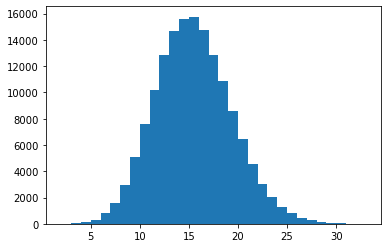

In [18]:
proba_param = {"lam": 15}
prob = get_probability_distribution(len(users), len(acc_log), proba_param, "poisson")
user_prob_distri = pd.DataFrame({"UID": users, "prob": prob})
print("Done!")

### Exponencial

Resources Done!


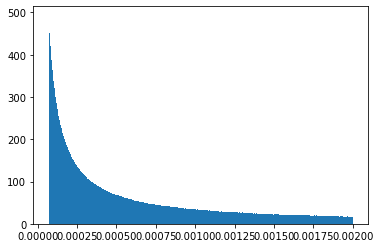

In [20]:
distribution_name = "Ex"

proba_param = {"lam": 0.002} # Cerca a la unidad mejor curvatura
prob = get_probability_distribution(len(rscs), len(acc_log), proba_param, "exponential")
res_prob_distri = pd.DataFrame({"UID": rscs, "prob": prob})
print("Resources Done!")

Done!


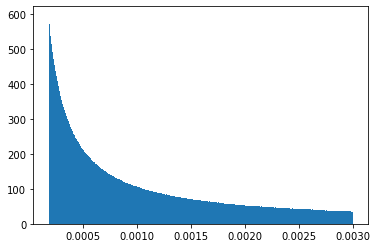

In [21]:
proba_param = {"lam": 0.003}
prob = get_probability_distribution(len(users), len(acc_log), proba_param, "exponential")
user_prob_distri = pd.DataFrame({"UID": users, "prob": prob})
print("Done!")

### Uniform

Resources Done!


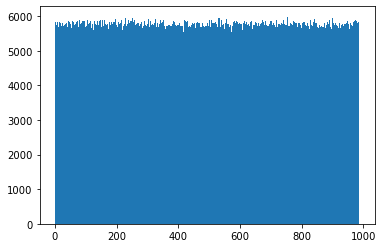

In [117]:
distribution_name = "Un"

proba_param = {"low": 0, "high": len(rscs)}
prob = get_probability_distribution(len(rscs), len(acc_log), proba_param, "uniform")
res_prob_distri = pd.DataFrame({"UID": rscs, "prob": prob})
print("Resources Done!")

Done!


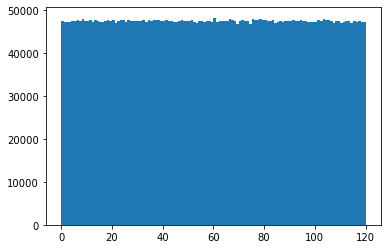

In [118]:
proba_param = {"low": 0, "high": len(users)}
prob = get_probability_distribution(len(users), len(acc_log), proba_param, "uniform")
user_prob_distri = pd.DataFrame({"UID": users, "prob": prob})
print("Done!")

## Creating distribution

In [27]:
### Only for AMZ and ML dataset

# We duplicate the access log
alter_acc_log = acc_log.append(acc_log, ignore_index=True)
alter_acc_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503586 entries, 0 to 503585
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uname        503586 non-null  int64 
 1   position     503586 non-null  object
 2   departmentu  503586 non-null  object
 3   crsTaken     503586 non-null  object
 4   crsTaught    503586 non-null  object
 5   isChair      503586 non-null  int64 
 6   rname        503586 non-null  object
 7   type         503586 non-null  object
 8   student      503586 non-null  object
 9   rDepartment  503586 non-null  object
 10  csr          503586 non-null  object
 11  op           503586 non-null  object
 12  ACTION       503586 non-null  int64 
dtypes: int64(3), object(10)
memory usage: 49.9+ MB


In [28]:
# El que tenga más tamaño es el primero en ejecutarse.
# Evitar demsaida pérdida de información

if len(users) > len(rscs):
    alter_acc_log = get_sample_by_distribution(acc_log, len(acc_log), user_prob_distri, "uname")
    print("*** Users Done! ***")
    alter_acc_log = get_sample_by_distribution(alter_acc_log, len(alter_acc_log), res_prob_distri, "rname")
    print("*** Res Done! ***")
else:
    alter_acc_log = get_sample_by_distribution(acc_log, len(acc_log), res_prob_distri, "rname")
    print("*** Res Done! ***")
    alter_acc_log = get_sample_by_distribution(alter_acc_log, len(alter_acc_log), user_prob_distri, "uname")
    print("*** Users Done! ***")

*** Users Done! ***
*** Res Done! ***


In [29]:
#print("Number of users: \t", len(alter_acc_log[USER_ATTRS[str_dataset]].drop_duplicates()))
print("Number of users: \t", len(alter_acc_log.uname.drop_duplicates()))
#print("Number of Resources: \t", len(alter_acc_log[RES_ATTRS[str_dataset]].drop_duplicates()))
print("Number of Resources: \t", len(alter_acc_log.rname.drop_duplicates()))
print("Size of AL: \t", len(alter_acc_log))
print("Size of +AL: \t",len(alter_acc_log[alter_acc_log.ACTION==1]),
      (len(alter_acc_log[alter_acc_log.ACTION==1])/len(alter_acc_log))*100)
print("Size of -AL: \t",len(alter_acc_log[alter_acc_log.ACTION==0]),
      (len(alter_acc_log[alter_acc_log.ACTION==0])/len(alter_acc_log))*100)

Number of users: 	 101
Number of Resources: 	 24
Size of AL: 	 251764
Size of +AL: 	 3536 1.4044899191306144


Size of -AL: 	 248228 98.59551008086939


In [30]:
distribution_name, str_dataset

('Rw', 'UN')

In [20]:
### Save the access log
#alter_acc_log.to_csv("../data/"+str_dataset+"/"+str_dataset+"-"+distribution_name+".csv")
#alter_acc_log.to_csv(str_dataset+"-"+distribution_name+".csv")
alter_acc_log.to_csv(str_dataset+"-OP-"+distribution_name+".csv")

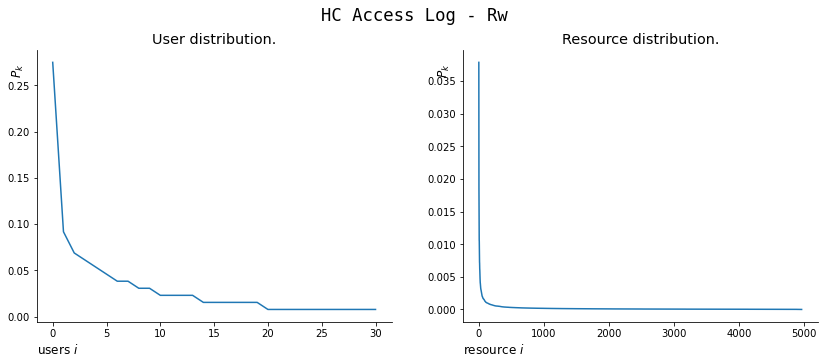

In [12]:
fig, ax = plt.subplots(1,2,figsize=(14, 5))

### USUERS (LEFT)
ax[0].spines[['right', 'top']].set_visible(False)
to_plot = alter_acc_log["uname"].value_counts(normalize=True)
ax[0].plot(range(len(to_plot)), to_plot)
ax[0].set_xlabel('users $i$', loc="left", size="large")
ax[0].set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax[0].yaxis.set_label_coords(-0.03,0.95)
ax[0].set_title("User distribution.", size="x-large", x=0.5, y=1, parse_math=True)
plt.suptitle(str_dataset+" Access Log", size="xx-large", family='monospace', x=0.15, y=1)

### RESOURCES (RIGHT)
ax[1].spines[['right', 'top']].set_visible(False)
to_plot = alter_acc_log["rname"].value_counts(normalize=True)
ax[1].plot(range(len(to_plot)), to_plot)
ax[1].set_xlabel('resource $i$', loc="left", size="large")
ax[1].set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax[1].yaxis.set_label_coords(-0.03,0.95)
ax[1].set_title("Resource distribution.", size="x-large", x=0.5, y=1, parse_math=True)

plt.suptitle(str_dataset+" Access Log - "+distribution_name, size="xx-large", family='monospace', x=0.5, y=1)
plt.show()